In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch, predict_with_auc, show_lmer, set_seaborn_style, plot_tertile_split
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS
from hmpai.pytorch.mamba import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
set_global_seed(42)
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ['rt', 'participant', 'epochs']
subset_cond = None # 'speed'|'accuracy'|None
skip_samples = 62
cut_samples = 63

In [3]:
norm_fn = norm_mad_zscore
# Shortcut so they dont have to be recalculated each time
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}

norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
class_weights = train_data.statistics["class_weights"]
testval_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)

In [4]:
# test_loader_sp = DataLoader(
#     test_data_sp, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
# )
# test_loader_acc = DataLoader(
#     test_data_ac, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
# )
# behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

In [7]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader = DataLoader(
    testval_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
)
# val_loader = DataLoader(
#     val_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
# )

### Examining

In [11]:
chk_path = Path("../../models/mamba_conv_jitter_both_ac.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "embed_dim": 128,
    "n_channels": 19,
    "n_classes": len(labels),
    "n_layers": 5,
    "global_pool": False,
    "dropout": 0.1,
}
model = MambaModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.pretraining = False
model.global_pool = False
model.eval();

In [8]:
chk_path = Path("../../models/mamba_low.pt")
checkpoint = load_model(chk_path)

model = base_mamba()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [9]:
# data_sp = predict_with_auc(model, test_loader_sp, info_to_keep, SAT_CLASSES_ACCURACY)
# data_acc = predict_with_auc(model, test_loader_acc, info_to_keep, SAT_CLASSES_ACCURACY)
data = predict_with_auc(model, test_loader, info_to_keep, SAT_CLASSES_ACCURACY)

# data = pd.concat([data_sp, data_acc])
data = data.merge(
    behaviour_sat2, left_on=["participant", "epochs"], right_on=["participant", "trial"]
)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


In [15]:
data

,rt_x,participant,epochs,negative_auc,encoding_auc,decision_auc,confirmation_auc,response_auc,FC,SAT,...,contrast,N200,trial,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence
0,0.409180,S1,1,520.128662,0.853683,0.908630,0.624044,0.484987,1.0,speed,...,1,NaN,1,right,1,409.179688,362.304685,46.875002,SA,CR
1,0.445312,S1,2,520.082520,0.789721,0.777591,0.683967,0.666240,1.0,speed,...,2,162.0,2,left,1,445.312500,407.226562,38.085938,SA,CR
2,0.469727,S1,5,519.342896,1.349506,1.019996,0.821908,0.465695,1.0,speed,...,2,NaN,5,right,1,469.726562,406.249998,63.476565,SA,CR
3,0.510742,S1,6,519.679871,1.096485,0.868481,0.778365,0.576770,1.0,speed,...,1,200.0,6,left,1,510.742188,451.171873,59.570315,MA,ICR
4,0.447266,S1,7,519.795715,1.045246,0.854334,0.757165,0.547528,1.0,speed,...,3,149.0,7,left,1,447.265625,344.726557,102.539068,SA,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17890,0.763672,S9,2442,519.077454,0.760256,1.181394,1.063370,0.917498,2.0,accuracy,...,1,198.0,2442,left,1,763.671875,541.015622,222.656253,MA,CIR
17891,1.105469,S9,2443,518.185425,1.045205,1.325078,1.551700,0.892604,2.0,accuracy,...,3,211.0,2443,left,0,1105.468750,893.554685,211.914065,MA,IIIR
17892,0.787109,S9,2444,518.810791,1.286419,1.097009,0.975182,0.830591,2.0,accuracy,...,2,127.0,2444,left,1,787.109375,524.414062,262.695312,SA,CR
17893,1.319336,S9,2445,518.243225,0.858843,1.290489,1.675368,0.932052,2.0,accuracy,...,1,209.0,2445,left,1,1319.335938,1140.625005,178.710932,MA,IIIICCR


#### Regression

---ENCODING---
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~encoding_auc*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 17895	 Groups: {'participant': 8.0}

Log-likelihood: -9004.225 	 AIC: 18018.451

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.013  0.115

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~encoding_auc*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 17895	 Groups: {'participant': 8.0}

Log-likelihood: -9004.225 	 AIC: 18018.451

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.013  0.115

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)               1.798   1.478    2.118  0.163  6.036      4.384   
encoding_auc 

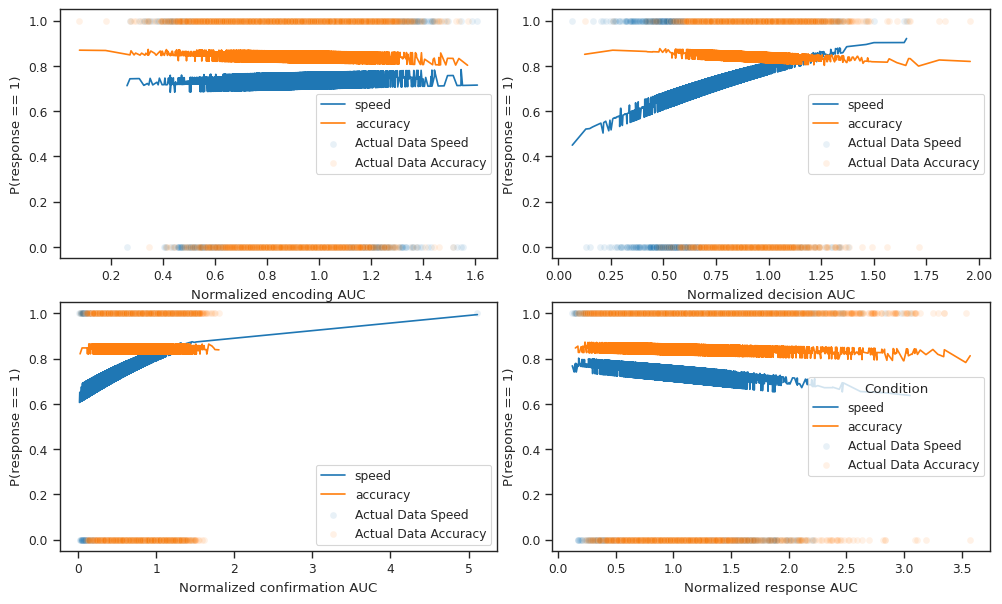

In [10]:
# show_lmer(SAT_CLASSES_ACCURACY, data, formula="response ~ SAT * - * rt_x + (1|participant)")
show_lmer(SAT_CLASSES_ACCURACY, data, formula="response ~ ?r * SAT + (1|participant)")

#### Tertile split boxplot with per-participant lines

encoding


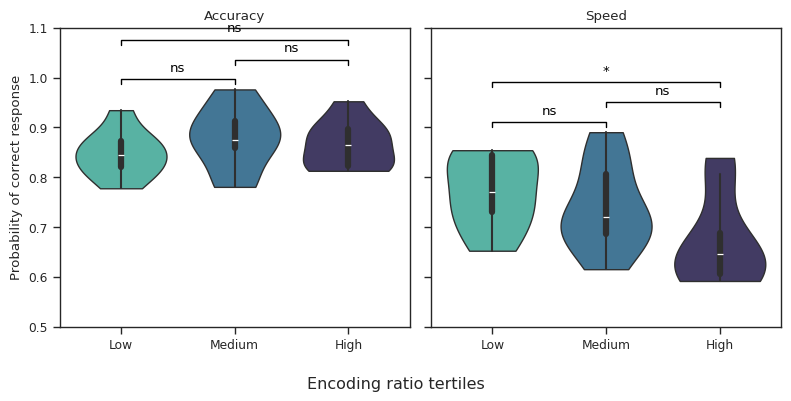

decision


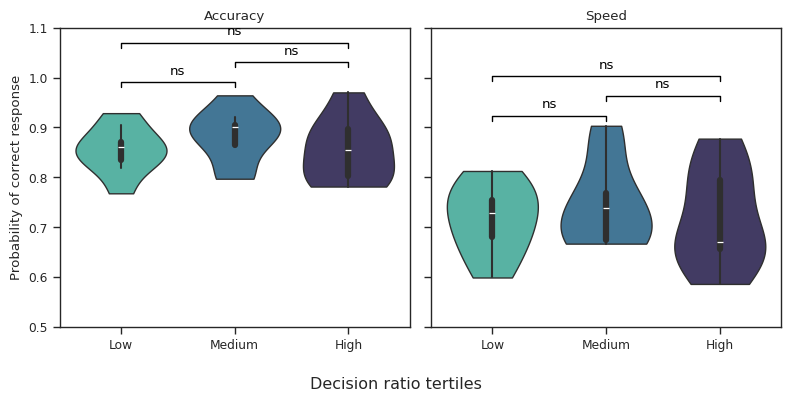

confirmation


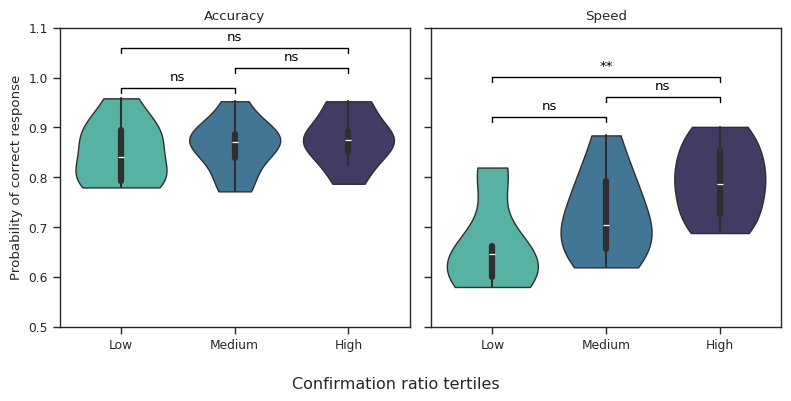

response


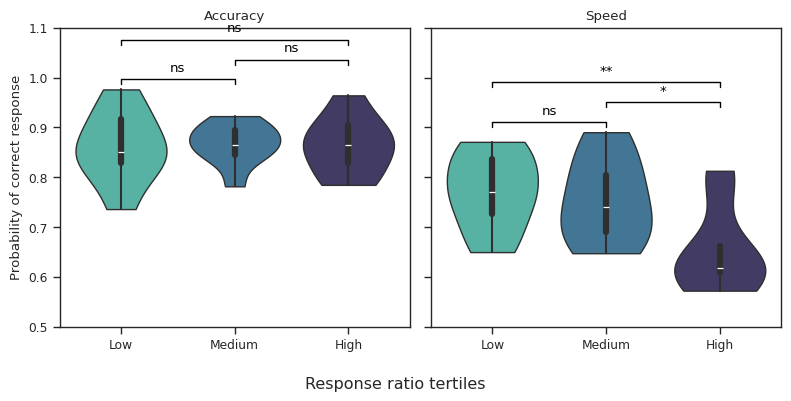

In [10]:
for label in labels[1:]:
    print(label)
    plot_tertile_split(data, f'{label}_ratio', ['accuracy', 'speed'], calc_tertile_over_condition=False, normalize='time')

#### Histogram of confirmation AUC ratio of speed vs. accuracy

In [9]:
data["confirmation_auc"].describe()

count    17895.000000
mean         0.669713
std          0.316355
min          0.018136
25%          0.422634
50%          0.658650
75%          0.895078
max          5.112421
Name: confirmation_auc, dtype: float64

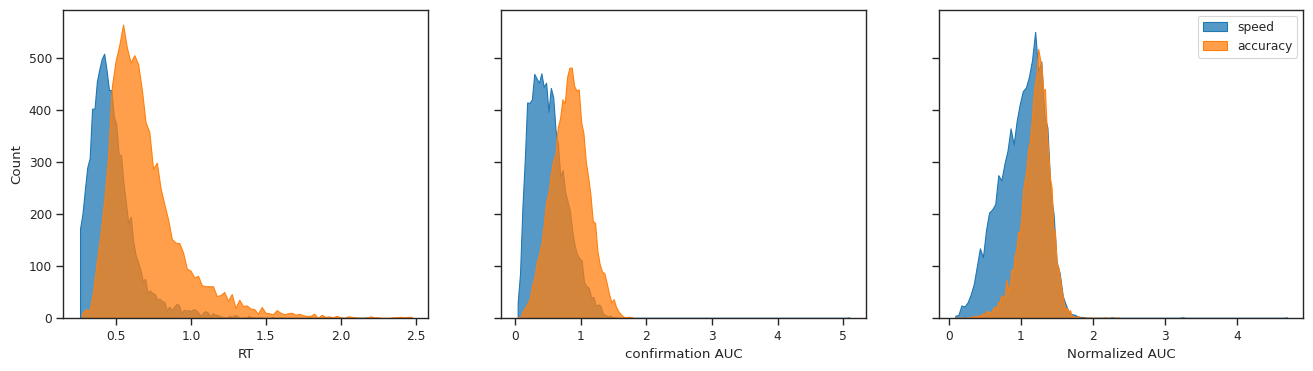

In [10]:
# data["ratio"] = (data[f"confirmation_auc"]) / data["rt_x"]
set_seaborn_style()
auc_columns = [column for column in data.columns if column.endswith('_auc') and not column.startswith('negative')]
data["sum_auc"] = data[auc_columns].sum(axis=1)
# data['rt_x_norm'] = (data['rt_x'] - data['rt_x'].min()) / (data['rt_x'].max() - data['rt_x'].min())
# Normalized operation certainty
data['ratio'] = data['confirmation_auc'] / data['rt_x']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
for condition in ['speed', 'accuracy']:
    subset = data[data.SAT == condition]
    sns.histplot(subset['rt_x'], element="poly", label=condition, ax=ax[0])
    sns.histplot(subset['confirmation_auc'], element="poly", label=condition, ax=ax[1])
    sns.histplot(subset['ratio'], element="poly", label=condition, ax=ax[2])

ax[0].set_xlabel('RT')
ax[1].set_xlabel('confirmation AUC')
ax[2].set_xlabel('Normalized AUC')
plt.legend()
plt.show()

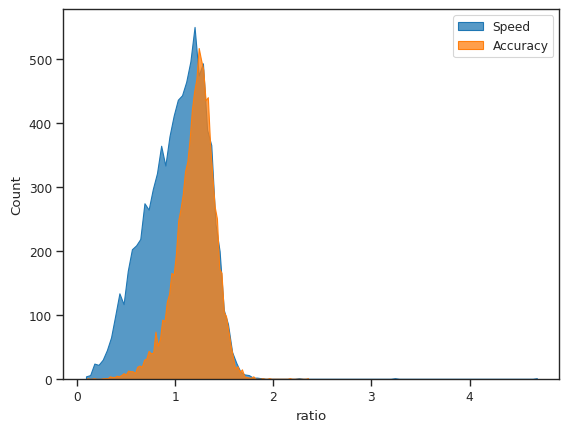

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
data["ratio"] = (data[f"confirmation_auc"]) / data["rt_x"]

sns.histplot(data[data["SAT"] == 'speed'].ratio, element="poly", label="Speed")
sns.histplot(data[data["SAT"] == 'accuracy'].ratio, element="poly", label="Accuracy")
plt.legend()
# plt.xlim(0, 0.010)
plt.show();

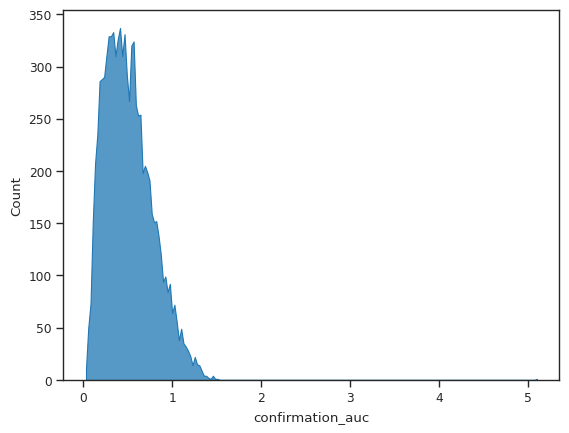

In [26]:
sns.histplot(data[data["SAT"] == 'speed'].confirmation_auc, element="poly", label="Speed", bins=200)
plt.show()

#### EMG Sequence testing

In [90]:
data["EMG_sequence"].unique()

array(['CR', 'ICR', 'IR', 'IICR', 'IIR', 'IICIR', 'IICCR', 'CCCR', 'CCR',
       'CICR', 'CIIR', 'CCCCCR', 'CIR', 'ICCR', 'R', 'CCIIR', 'ICIR',
       'CCIR', 'CCCIR', 'ICICR', 'IIIR', 'IIIICR', 'CCICR', 'IIICIR',
       'IIICR', 'CICIR', 'CCCCCCR', 'IIIIIIIICCR', 'CCCCR', 'CCCCIR',
       'ICCCCCR', 'ICICCIR', 'CCCCCCCCIR', 'IICIIR', 'IIIIICR', 'CIICR',
       'IIIIIIIICIR', 'IIIIIIICR', 'CIIIR', 'CCCICR', 'IIIIR', 'IIIIIR'],
      dtype=object)

In [91]:
data["ratio"] = (data[f"decision_auc"] / 256) / data["rt_x"]
# Select trials where the participant had more than one EMG pulse, resulting in an INCORRECT guess
IR_cond = data["EMG_sequence"].str.match("..*IR")
# Select trials where the participant had more than one EMG pulse, resulting in a CORRECT guess
CR_cond = data["EMG_sequence"].str.match("..*CR")
data["multiple_emg"] = False
data.loc[IR_cond | CR_cond, "multiple_emg"] = True
data.loc[IR_cond, "wrong"] = True
data.loc[CR_cond, "wrong"] = False

In [92]:
data

,rt_x,participant,epochs,pre-attentive_auc,encoding_auc,decision_auc,confirmation_auc,response_auc,FC,SAT,...,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence,ratio,multiple_emg,wrong
0,0.409180,S1,1,619.082214,0.985211,0.912470,0.323929,0.696176,1.0,speed,...,right,1,409.179688,362.304685,46.875002,SA,CR,0.008711,False,NaN
1,0.445312,S1,2,619.242310,1.055919,0.884720,0.360925,0.456118,1.0,speed,...,left,1,445.312500,407.226562,38.085938,SA,CR,0.007761,False,NaN
2,0.469727,S1,5,618.884216,1.101345,1.021444,0.350449,0.642567,1.0,speed,...,right,1,469.726562,406.249998,63.476565,SA,CR,0.008494,False,NaN
3,0.510742,S1,6,618.597778,1.084906,1.009842,0.522265,0.785205,1.0,speed,...,left,1,510.742188,451.171873,59.570315,MA,ICR,0.007723,True,False
4,0.447266,S1,7,618.704041,1.013898,0.983234,0.338576,0.960285,1.0,speed,...,left,1,447.265625,344.726557,102.539068,SA,CR,0.008587,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,0.961914,S12,2237,616.287231,0.903779,1.098338,1.036111,2.674578,1.0,accuracy,...,left,1,961.914062,873.046872,88.867190,SA,CR,0.004460,False,NaN
4446,1.284180,S12,2239,617.505066,1.154456,1.080392,1.323645,0.936441,1.0,accuracy,...,left,1,1284.179688,1199.218753,84.960935,SA,CR,0.003286,False,NaN
4447,0.876953,S12,2240,616.881775,0.971936,0.950306,0.742001,2.453975,1.0,accuracy,...,left,0,876.953125,786.132810,90.820315,SA,IR,0.004233,False,NaN
4448,0.641602,S12,2241,618.075439,1.111495,1.031502,0.631863,1.149676,1.0,accuracy,...,right,1,641.601562,581.054690,60.546872,SA,CR,0.006280,False,NaN


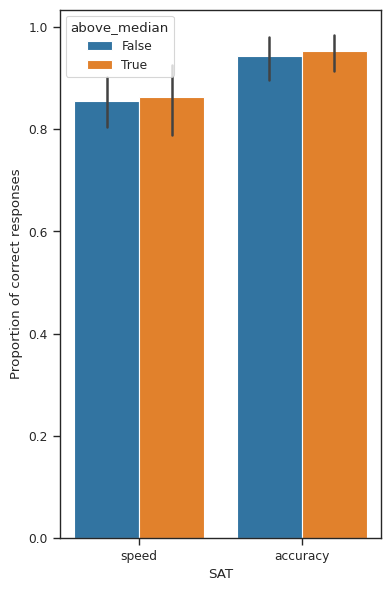

In [96]:
plt.figure(figsize=(4, 6))
sns.barplot(data=data[data['wrong'] == False], x='SAT', y='response', hue="above_median")
plt.ylabel("Proportion of correct responses")
# plt.ylim(0, 1)
plt.plot();

<Axes: xlabel='SAT', ylabel='ratio'>

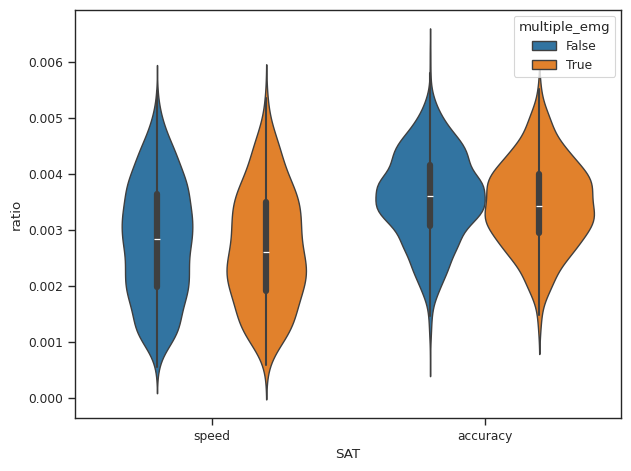

In [99]:
sns.violinplot(x='SAT', y='ratio', data=data, hue='multiple_emg')

<Axes: xlabel='ratio', ylabel='rt_x'>

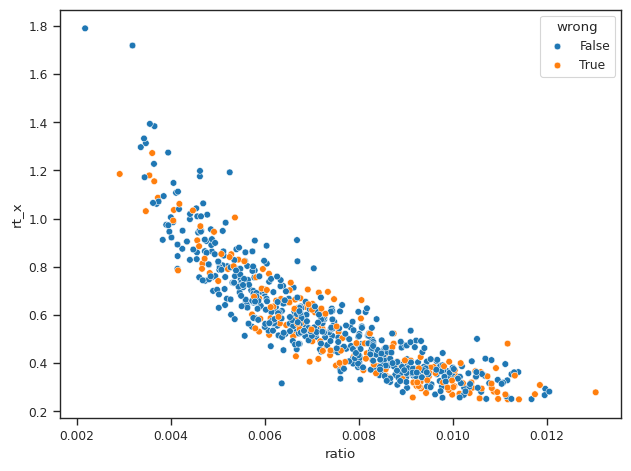

In [40]:
sns.scatterplot(data=data[data["SAT"] == "speed"], x="ratio", y="rt_x", hue="wrong")

#### Other plots

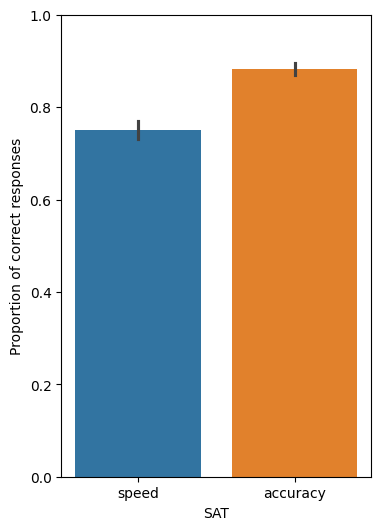

In [29]:
plt.figure(figsize=(4, 6))
sns.barplot(data=data, x='SAT', y='response', hue="SAT")
plt.ylabel("Proportion of correct responses")
plt.ylim(0, 1)
plt.plot();

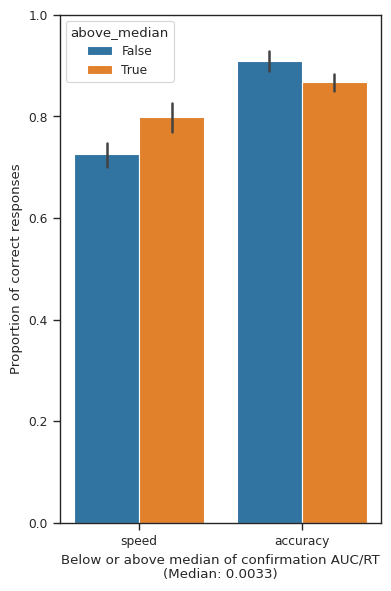

In [95]:
from hmpai.visualization import plot_median_split_error_rate


plot_median_split_error_rate(data, "confirmation")

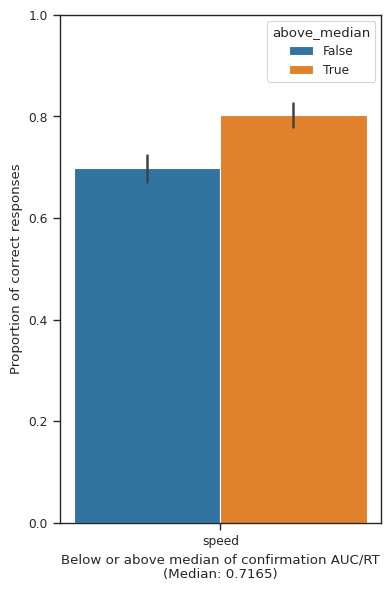

In [51]:
plot_median_split_error_rate(data[data.SAT == "speed"].copy(), "confirmation")

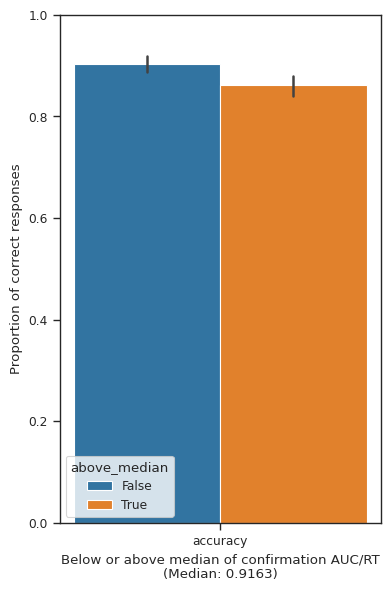

In [52]:
# More confirmation implies longer RT > more errors? Shorter decision?
plot_median_split_error_rate(data[data.SAT == "accuracy"].copy(), "confirmation")

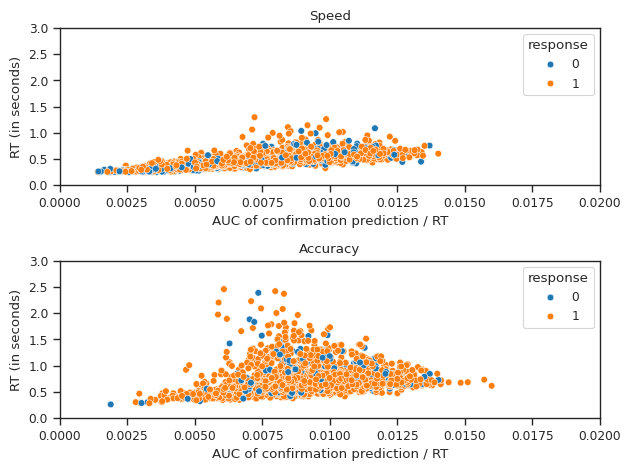

In [35]:
# Confirmation
plt.rcParams["figure.autolayout"] = True
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("tab10")
fig, ax = plt.subplots(2, 1)
ax[0].title.set_text("Speed")
sns.scatterplot(
    data[data["SAT"] == "speed"], x="ratio", y="rt_x", ax=ax[0], hue="response"
)
ax[1].title.set_text("Accuracy")
sns.scatterplot(
    data[data["SAT"] == "accuracy"], x="ratio", y="rt_x", ax=ax[1], hue="response"
)
plt.setp(
    ax,
    xlim=(0, 0.02),
    ylim=(0, 3),
    ylabel="RT (in seconds)",
    xlabel="AUC of confirmation prediction / RT",
)
plt.show()
# Median split of 0.3/knikpunt split, error rate vergelijken

KeyboardInterrupt: 

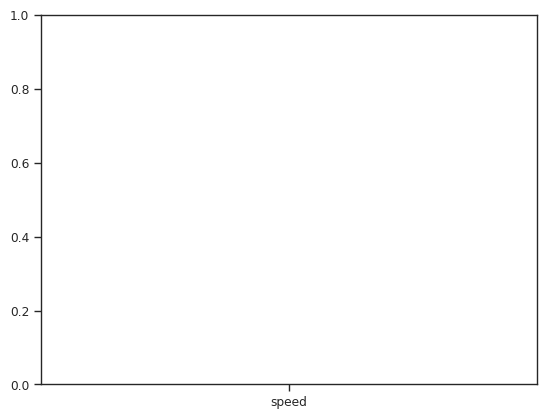

In [38]:
sns.violinplot(x="SAT", y="ratio", data=data, split=True, hue="response")